# Executive-Compensation-Company-Performance-A-Longitudinal-Analysis #

## Table of Contents:
1. [Data Pre-Processing](#1.-Data-Pre-Processing)
   
   1.1. [Audit, Top Categories & Modal](#1.1.-Audit,-Top-Categories-&-Modal)

   1.2. [Computing lags & filling dummies](#1.2.-Computing-lags-&-filling-dummies)

   1.3. [Calculating Annual Price Return](#1.3.-Calculating-Annual-Price-Return)

   1.4. [Handling missing data & duplicates](#1.4.-Handling-missing-data-&-duplicates)
   
2. [Model Implementation](#2.-Model-Implementation)

   2.1. [Panel Object & Basic Descriptives](#2.1.-Panel-Object-&-Basic-Descriptives)

   2.2. [Fixed-Effects](#2.2.-Fixed-Effects)

   2.3. [Random Effects & Hausam Test](#2.3.-Random-Effects-&-Hausman-Test)
   
3. [Model Evaluation & Robustness](#3.-Model-Evaluation-&-Robustness)

   3.1. [Wald: Joint significance of both lags](#3.1.-Wald:-Joint-significance-of-both-lags)
   
   3.2. [Alternative SEs](#3.2.-Alternative-SEs)

   3.3. [Heterogeneity by sector dummy](#3.3.-Heterogeneity-by-sector-dummy)

   3.4. [Influence: leave-one-firm-out (LOEO) stability check](#3.4.-Influence:-leave-one-firm-out-(LOEO)-stability-check)

   3.5. [Multicollinearity (VIF) on regressors used in FE](#3.5.-Multicollinearity-(VIF)-on-regressors-used-in-FE)

   3.6. [Winsorisation robustness](#3.6.-Winsorisation-robustness)

   3.7. [Exporting tables](#3.7.-Exporting-tables)

4. [Visuals](#4.-Visuals)

   4.1. [Time trend of mean annual return](#4.1.-Time-trend-of-mean-annual-return)

   4.2. [Histograms: DV and logLag1](#4.2.-Histograms:-DV-and-logLag1)

   4.3. [Binned scatter: logLag1 vs DV](#4.3.-Binned-scatter:-logLag1-vs-DV)

   4.4. [Coefficient plot with 95% CI from FE results](#4.4.-Coefficient-plot-with-95%-CI-from-FE-results)

### **1. Data Pre-Processing**

#### 1.1. Audit, Top Categories & Modal

In [5]:
#Quick env print for reproducibility in appendix
import platform, pandas as pd, numpy as np, statsmodels, linearmodels
print("[versions]",
      "python", platform.python_version(),
      "| pandas", pd.__version__,
      "| numpy", np.__version__,
      "| statsmodels", statsmodels.__version__,
      "| linearmodels", linearmodels.__version__)

[versions] python 3.12.4 | pandas 2.2.2 | numpy 1.26.4 | statsmodels 0.14.2 | linearmodels 6.1


In [6]:
#std libs + plotting + econometrics
import pandas as pd
import numpy as np, pathlib, textwrap, json, sys, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm

from pathlib import Path
import pandas as pd, json

!pip install linearmodels
from linearmodels.panel import PanelOLS, RandomEffects

warnings.filterwarnings("ignore")

In [7]:
#Paths + column names (single source of truth for headers)
PATH_IN  = "Final_Dataset.xlsx"
SHEET    = "Dataset"
PATH_OUT = "Final_Dataset_STWX.xlsx"  # new file; raw stays intact

ID_COL      = "Company"
YEAR_COL    = "Year"
COMP_COL    = "CEO Total Compensation (USD)"
PRICE_COL   = "Stock Price (USD)"
COUNTRY_COL = "Country"
SECTOR_COL  = "Industry"
U_COL = "Compensation / Revenue"
V_COL = "Compensation / Net Income"

#Raw Excel; not overwrite the original file
df = pd.read_excel(PATH_IN, sheet_name=SHEET)

In [8]:
#Audit
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nMissing %:\n", (df.isna().mean()*100).round(2).sort_values(ascending=False).head(15))

Shape: (330, 24)

Columns: ['Company', 'Country', 'Industry', 'Year', 'CEO Name', 'CEO Total Compensation (USD)', 'Base Salary (USD)', 'Bonus (USD)', 'Equity/Stock Awards (USD)', 'Revenue (USD)', 'Net Income (USD)', 'Market Capitalization (m USD)', 'Stock Price (USD)', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Number of Employees', 'Total Assets (USD)', 'Total Debt (USD)', 'Lagged Compensation (t-1)', 'Lagged Compensation (t-2)', 'Compensation / Revenue', 'Compensation / Net Income', 'Country Dummy', 'Sector Dummy']

Missing %:
 Sector Dummy                     100.0
Country Dummy                    100.0
Lagged Compensation (t-2)        100.0
Lagged Compensation (t-1)        100.0
Country                            0.0
Compensation / Net Income          0.0
Compensation / Revenue             0.0
Total Debt (USD)                   0.0
Total Assets (USD)                 0.0
Number of Employees                0.0
Return on Assets (ROA)             0.0
Return on Equity (ROE)   

In [9]:
#Duplicated firm-year check
dups = df.duplicated(subset=[ID_COL, YEAR_COL]).sum()
print(f"\nDuplicate (Company,Year) rows: {dups}")


Duplicate (Company,Year) rows: 0


In [10]:
#Picking most frequent category
top_countries = df[COUNTRY_COL].astype(str).str.strip().value_counts(dropna=True)
top_sectors   = df[SECTOR_COL].astype(str).str.strip().value_counts(dropna=True)

print("\nTop Countries (count | %):")
print(pd.concat([top_countries, (top_countries/top_countries.sum()*100).round(2)], axis=1).rename(columns={0:"count",1:"pct"}).head(10))
print("\nTop Industries (count | %):")
print(pd.concat([top_sectors, (top_sectors/top_sectors.sum()*100).round(2)], axis=1).rename(columns={0:"count",1:"pct"}).head(10))


Top Countries (count | %):
         count  count
Country              
Germany     66  20.00
USA         55  16.67
France      55  16.67
Japan       55  16.67
UK          44  13.33
China       33  10.00
Canada      22   6.67

Top Industries (count | %):
                     count  count
Industry                         
Consumer/Industrial     99  30.00
Finance                 77  23.33
Pharma/Healthcare       66  20.00
Technology              55  16.67
Energy                  33  10.00


In [11]:
#Choosing modal
def pick_modal(vcounts: pd.Series) -> str:
    max_count = vcounts.iloc[0]
    tied = vcounts[vcounts == max_count]
    if len(tied) == 1:
        return tied.index[0]
    return sorted(tied.index.astype(str))[0]

FOCUS_COUNTRY = pick_modal(top_countries)
FOCUS_SECTOR  = pick_modal(top_sectors)

print("\nSelected modal categories:")
print(f"FOCUS_COUNTRY = {FOCUS_COUNTRY} (count={int(top_countries[FOCUS_COUNTRY])})")
print(f"FOCUS_SECTOR  = {FOCUS_SECTOR}  (count={int(top_sectors[FOCUS_SECTOR])})")


Selected modal categories:
FOCUS_COUNTRY = Germany (count=66)
FOCUS_SECTOR  = Consumer/Industrial  (count=99)


#### 1.2. Computing lags & filling dummies

In [13]:
#Creating dummies using modal categories

PATH_OUT = "Final_Dataset_STWX.xlsx"

#Label clean and year numeric for correct lagging
df[COUNTRY_COL] = df[COUNTRY_COL].astype(str).str.strip()
df[SECTOR_COL]  = df[SECTOR_COL].astype(str).str.strip()
df[YEAR_COL]    = pd.to_numeric(df[YEAR_COL], errors="coerce")
df = df.sort_values([ID_COL, YEAR_COL], ascending=True).copy()

#Computing lags of compensation within firm
df["Lagged Compensation (t-1)"] = df.groupby(ID_COL)[COMP_COL].shift(1)
df["Lagged Compensation (t-2)"] = df.groupby(ID_COL)[COMP_COL].shift(2)

In [14]:
#Filling dummies with the selected modal choices
##Modal dummies: 1 if equals selected modal, else 0 (Int64 keeps NaN if any)
df["Country Dummy"] = (df[COUNTRY_COL] == FOCUS_COUNTRY).astype("Int64")
df["Sector Dummy"]  = (df[SECTOR_COL]  == FOCUS_SECTOR ).astype("Int64")

#Saving into new excel file
df.to_excel(PATH_OUT, sheet_name="Dataset", index=False)
print(f"Preprocessing saved to: {PATH_OUT}")
print("Focus choices → Country:", FOCUS_COUNTRY, "| Sector:", FOCUS_SECTOR)

Preprocessing saved to: Final_Dataset_STWX.xlsx
Focus choices → Country: Germany | Sector: Consumer/Industrial


#### 1.3. Calculating Annual Price Return

In [16]:
PRICE_COL = "Stock Price (USD)"

#Robust money: float converter (handles $, commas, EU decimals, dashes)
def to_numeric_usd(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s.replace({"": np.nan, "-": np.nan, "—": np.nan, "–": np.nan, "nan": np.nan, "None": np.nan}) #'missing' tokens → NaN
    s = s.str.replace(r"^\((.*)\)$", r"-\1", regex=True) #parenthesesing negatives
    s_clean = s.str.replace(r"[^\d\.\,\-\s]", "", regex=True) #removing currency symbols and non-numeric letters
    s_clean = s_clean.str.replace("\u00A0", "", regex=False).str.replace(" ", "", regex=False) #normalising weird spaces
    
    s_us = s_clean.str.replace(",", "", regex=False) #removing commas as thousands
    num1 = pd.to_numeric(s_us, errors="coerce")
    
    need2 = num1.isna() & s_clean.notna() #dropping thousands '.', replacing ',' with '.'
    s_eu = s_clean[need2].str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    num2 = pd.to_numeric(s_eu, errors="coerce")
    
    out = num1.copy()
    out[need2] = out[need2].fillna(num2)

    return out

In [17]:
#Current dtype with examples
print("Before conversion:", df[PRICE_COL].dtype)
print("Raw examples:", df[PRICE_COL].dropna().astype(str).head(5).tolist())

Before conversion: object
Raw examples: ['8.49', '11.620999999999999', '18.916', '18.962', '21.508']


In [18]:
#Converting to numeric with robust cleaner
price_numeric = to_numeric_usd(df[PRICE_COL])

#Quick QC
n_total   = len(price_numeric)
n_nan_old = df[PRICE_COL].isna().sum()
n_nan_new = price_numeric.isna().sum()
n_fixed   = (df[PRICE_COL].notna() & price_numeric.notna()).sum()

print(f"Converted price to numeric. Non-NaN fixed/parsed: {n_fixed}/{n_total - n_nan_old}")
print(f"Remaining NaN after parse: {n_nan_new} (these rows will yield NaN returns)")

Converted price to numeric. Non-NaN fixed/parsed: 325/330
Remaining NaN after parse: 5 (these rows will yield NaN returns)


In [19]:
#Building in-memory returns frame
tmp = df[[ID_COL, YEAR_COL]].copy()
tmp["Price_numeric"] = price_numeric

tmp = tmp.sort_values([ID_COL, YEAR_COL])
tmp["AnnualPriceReturn"] = tmp.groupby(ID_COL)["Price_numeric"].pct_change()

#Merge back in-memory
df_model = df.merge(
    tmp[[ID_COL, YEAR_COL, "AnnualPriceReturn"]],
    on=[ID_COL, YEAR_COL],
    how="left"
)

In [20]:
#Redefining constants
if 'ID_COL'   not in globals(): ID_COL   = "Company"
if 'YEAR_COL' not in globals(): YEAR_COL = "Year"
if 'COMP_COL' not in globals(): COMP_COL = "CEO Total Compensation (USD)"
if 'DV_COL'    not in globals(): DV_COL    = "AnnualPriceReturn"
if 'LAG1_COL'  not in globals(): LAG1_COL  = "Lagged Compensation (t-1)"
if 'LAG2_COL'  not in globals(): LAG2_COL  = "Lagged Compensation (t-2)"

#Check
for c in [ID_COL, YEAR_COL, DV_COL, LAG1_COL, LAG2_COL]:
    assert c in df_model.columns, f"Column not found in df_model: {c}"
print("[ok] constants defined & columns found.")

[ok] constants defined & columns found.


In [21]:
#Making sure key cols are numeric float
for c in [DV_COL, LAG1_COL, LAG2_COL]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce").astype(float)

#Checking Year monotonic per firm
bad = (
    df_model.sort_values([ID_COL, YEAR_COL])
            .groupby(ID_COL)[YEAR_COL]
            .apply(lambda s: (s.diff().dropna() < 0).any())
)
print(f"[check] firms with non-monotonic years: {int(bad.sum())}")

[check] firms with non-monotonic years: 0


In [22]:
#DV extremes (awareness)
q = df_model[DV_COL].quantile([.01,.05,.95,.99])
print(f"[check] {DV_COL} percentiles:\n{q}")

[check] AnnualPriceReturn percentiles:
0.01   -0.425717
0.05   -0.279578
0.95    0.565384
0.99    1.190030
Name: AnnualPriceReturn, dtype: float64


In [23]:
#Check new Annual Price Return column has been included
print(df_model[[ID_COL, YEAR_COL, PRICE_COL, "AnnualPriceReturn"]].head(12))

       Company  Year Stock Price (USD)  AnnualPriceReturn
0   APPLE INC.  2010              8.49                NaN
1   APPLE INC.  2011            11.621           0.368787
2   APPLE INC.  2012            18.916           0.627743
3   APPLE INC.  2013            18.962           0.002432
4   APPLE INC.  2014            21.508           0.134269
5   APPLE INC.  2015           28.3175           0.316603
6   APPLE INC.  2016           26.6615          -0.058480
7   APPLE INC.  2017           33.6275           0.261276
8   APPLE INC.  2018           47.4885           0.412192
9   APPLE INC.  2019            46.934          -0.011677
10  APPLE INC.  2020           95.5665           1.036189
11      Airbus  2010           23.3696                NaN


#### 1.4. Handling missing data & duplicates

In [25]:
LAG1_COL = "Lagged Compensation (t-1)"
LAG2_COL = "Lagged Compensation (t-2)"
DV_COL   = "AnnualPriceReturn"

In [26]:
#Duplicates
exact_dups = df_model.duplicated().sum()
fw_dups    = df_model.duplicated(subset=[ID_COL, YEAR_COL], keep=False).sum()
print(f"\nExact duplicate rows: {exact_dups}")
print(f"Firm-year duplicate rows: {fw_dups}")
if fw_dups:
    display(
        df_model[df_model.duplicated(subset=[ID_COL, YEAR_COL], keep=False)]
        .sort_values([ID_COL, YEAR_COL])
        .head(10)
    )


Exact duplicate rows: 0
Firm-year duplicate rows: 0


In [27]:
#Missing Values
key_vars = [DV_COL, COMP_COL, LAG1_COL, LAG2_COL]
print("Rows × Cols:", df_model.shape)

print("\n% Missing (key vars):")
print((df_model[key_vars].isna().mean()*100).round(2).sort_values(ascending=False))

print("\n% Missing by YEAR (key vars):")
display(
    df_model.groupby(YEAR_COL)[key_vars]
            .apply(lambda x: (x.isna().mean()*100).round(1))
)

Rows × Cols: (330, 25)

% Missing (key vars):
Lagged Compensation (t-2)       20.00
Lagged Compensation (t-1)       10.91
AnnualPriceReturn               10.61
CEO Total Compensation (USD)     0.00
dtype: float64

% Missing by YEAR (key vars):


,AnnualPriceReturn,CEO Total Compensation (USD),Lagged Compensation (t-1),Lagged Compensation (t-2)
Year,,,,
2010,100.0,0.0,100.0,100.0
2011,3.3,0.0,3.3,100.0
2012,3.3,0.0,3.3,3.3
2013,3.3,0.0,3.3,3.3
2014,3.3,0.0,3.3,3.3
2015,3.3,0.0,3.3,3.3
2016,0.0,0.0,3.3,3.3
2017,0.0,0.0,0.0,3.3
2018,0.0,0.0,0.0,0.0


In [28]:
#Handling missing values
model_now  = df_model.dropna(subset=[DV_COL, COMP_COL]).copy()           
model_lags = df_model.dropna(subset=[DV_COL, LAG1_COL, LAG2_COL]).copy()

print("\nShapes after handling missing (no duplicate edits):")
print(" - model_now :", model_now.shape,  "(kept rows with DV & current comp)")
print(" - model_lags:", model_lags.shape, "(kept rows with DV & t-1 & t-2)")


Shapes after handling missing (no duplicate edits):
 - model_now : (295, 25) (kept rows with DV & current comp)
 - model_lags: (264, 25) (kept rows with DV & t-1 & t-2)


In [29]:
#Check
assert exact_dups == 0, "Found exact duplicate rows."
assert fw_dups == 0,    "Found firm-year duplicate rows."

### **2. Model Implementation**

#### 2.1. Panel object & Basic Descriptives

In [32]:
from linearmodels.panel import PanelOLS, RandomEffects
import statsmodels.api as sm

DVNAME  = DV      if 'DV'  in globals() else DV_COL
LAG1    = L1      if 'L1'  in globals() else LAG1_COL
LAG2    = L2      if 'L2'  in globals() else LAG2_COL

#Building panel index
panel = model_lags.set_index([ID_COL, YEAR_COL]).sort_index().copy()

#Coerce to numeric float before log/estimation
for c in [DVNAME, LAG1, LAG2]:
    panel[c] = pd.to_numeric(panel[c], errors="coerce").astype(float)

#No logs of negatives; set negatives to NaN
for c in [LAG1, LAG2]:
    bad = (panel[c] < 0).sum()
    if bad:
        print(f"Note: {bad} negative values in {c}; setting to NaN before log1p.")
        panel.loc[panel[c] < 0, c] = np.nan

#Log-transform lags to keep original column names untouched
panel["logLag1"] = np.log1p(panel[LAG1])
panel["logLag2"] = np.log1p(panel[LAG2])

#Basic descriptives
desc = panel[[DVNAME, LAG1, LAG2, "logLag1", "logLag2"]].describe(percentiles=[.1,.25,.5,.75,.9]).T
print(desc)

                           count          mean           std            min  \
AnnualPriceReturn          264.0  8.726832e-02  2.975361e-01      -0.578345   
Lagged Compensation (t-1)  264.0  9.480631e+06  1.680901e+07  100000.000000   
Lagged Compensation (t-2)  264.0  8.967106e+06  1.553568e+07       1.000000   
logLag1                    264.0  1.527500e+01  1.389069e+00      11.512935   
logLag2                    264.0  1.520056e+01  1.630271e+00       0.693147   

                                     10%           25%           50%  \
AnnualPriceReturn              -0.214362 -8.663476e-02  5.279126e-02   
Lagged Compensation (t-1)  434500.000000  2.307500e+06  5.950000e+06   
Lagged Compensation (t-2)  418400.000000  1.837500e+06  5.931500e+06   
logLag1                        12.981940  1.463976e+01  1.559890e+01   
logLag2                        12.943733  1.442353e+01  1.559578e+01   

                                    75%           90%           max  
AnnualPriceReturn     

#### 2.2. Fixed-Effects

In [34]:
#FE with firm & year effects; cluster SE by firm
X_FE = ["logLag1", "logLag2"]
fe_mod = PanelOLS(panel[DVNAME], panel[X_FE], entity_effects=True, time_effects=True)
fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)
print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0161
Estimator:                   PanelOLS   R-squared (Between):             -32.361
No. Observations:                 264   R-squared (Within):               0.0173
Date:                Mon, Aug 25 2025   R-squared (Overall):             -27.776
Time:                        19:20:57   Log-likelihood                    24.365
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8287
Entities:                          30   P-value                           0.1630
Avg Obs:                       8.8000   Distribution:                   F(2,224)
Min Obs:                       3.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             3.6472
                            

#### 2.3. Random Effects & Hausman Test

In [36]:
#RE with explicit constant (required by linearmodels)
X_RE = sm.add_constant(panel[X_FE], has_constant='add')
re_mod = RandomEffects(panel[DVNAME], X_RE)
re_res = re_mod.fit()
print(re_res.summary)

#Hausman test: comparing FE vs RE on common regressors
from scipy.stats import chi2
def hausman(fe, re, xcols):
    b_fe = fe.params.reindex(xcols).values
    b_re = re.params.reindex(xcols).values
    V_fe = fe.cov.reindex(index=xcols, columns=xcols).values
    V_re = re.cov.reindex(index=xcols, columns=xcols).values
    diff  = b_fe - b_re
    Vdiff = V_fe - V_re
    stat = float(diff.T @ np.linalg.pinv(Vdiff) @ diff)
    p = 1 - chi2.cdf(stat, len(xcols))
    return stat, len(xcols), p

print("Hausman:", hausman(fe_res, re_res, X_FE))

                        RandomEffects Estimation Summary                        
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0256
Estimator:              RandomEffects   R-squared (Between):              0.1141
No. Observations:                 264   R-squared (Within):               0.0122
Date:                Mon, Aug 25 2025   R-squared (Overall):              0.0064
Time:                        19:20:57   Log-likelihood                   -8.3711
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.4321
Entities:                          30   P-value                           0.0338
Avg Obs:                       8.8000   Distribution:                   F(2,261)
Min Obs:                       3.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             2.8105
                            

### **3. Model Evaluation & Robustness**

In [38]:
#Re-using objects
assert 'panel' in globals(), "Build `panel` first (from model_lags)."
assert all(c in panel.columns for c in ["logLag1","logLag2", DV_COL]), "Need logLag1/logLag2 + DV in `panel`."

#If FE model object not in memory, (re)fit it exactly as before
X_FE = ["logLag1", "logLag2"]
if 'fe_mod' not in globals() or 'fe_res' not in globals():
    fe_mod = PanelOLS(panel[DV_COL], panel[X_FE], entity_effects=True, time_effects=True)
    fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)

print("Baseline FE summary (already run above):")
print(fe_res.summary)

Baseline FE summary (already run above):
                          PanelOLS Estimation Summary                           
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0161
Estimator:                   PanelOLS   R-squared (Between):             -32.361
No. Observations:                 264   R-squared (Within):               0.0173
Date:                Mon, Aug 25 2025   R-squared (Overall):             -27.776
Time:                        19:20:57   Log-likelihood                    24.365
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8287
Entities:                          30   P-value                           0.1630
Avg Obs:                       8.8000   Distribution:                   F(2,224)
Min Obs:                       3.0000                                           
Max Obs:                       9.0000   F-statistic (robust):       

#### 3.1. Wald: Joint significance of both lags

In [40]:
#see the available parameter names
print("FE params:", fe_res.params.index.tolist())

FE params: ['logLag1', 'logLag2']


In [41]:
#Preferred
try:
    wald_both = fe_res.wald_test(formula="logLag1 = 0, logLag2 = 0")
    print("\n[Wald] H0: logLag1 = logLag2 = 0")
    print(wald_both)
except Exception as e:
    #Fallback
    import numpy as np, pandas as pd
    cols = fe_res.params.index.tolist()
    assert "logLag1" in cols and "logLag2" in cols, \
        f"Expected 'logLag1'/'logLag2' in params, got: {cols}"

    R = pd.DataFrame(0.0, index=["r1","r2"], columns=cols)
    R.loc["r1","logLag1"] = 1.0
    R.loc["r2","logLag2"] = 1.0

    wald_both = fe_res.wald_test(restriction=R.values, value=np.zeros(2))
    print("\n[Wald] (matrix fallback) H0: logLag1 = logLag2 = 0")
    print(wald_both)


[Wald] H0: logLag1 = logLag2 = 0
Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 7.2943
P-value: 0.0261
Distributed: chi2(2)


#### 3.2. Alternative SEs

In [43]:
#2-way clustering
fe_tw = fe_mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)
print("\n[FE] Two-way clustered SEs (entity & time):")
print(fe_tw.summary)


[FE] Two-way clustered SEs (entity & time):
                          PanelOLS Estimation Summary                           
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0161
Estimator:                   PanelOLS   R-squared (Between):             -32.361
No. Observations:                 264   R-squared (Within):               0.0173
Date:                Mon, Aug 25 2025   R-squared (Overall):             -27.776
Time:                        19:20:57   Log-likelihood                    24.365
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8287
Entities:                          30   P-value                           0.1630
Avg Obs:                       8.8000   Distribution:                   F(2,224)
Min Obs:                       3.0000                                           
Max Obs:                       9.0000   F-statistic (robust):   

In [44]:
#Kernel-robust (Bartlett)
fe_kern = fe_mod.fit(cov_type="kernel", kernel="bartlett", bandwidth=3)
print("\n[FE] Kernel-robust SEs (Bartlett, bw=3):")
print(fe_kern.summary)


[FE] Kernel-robust SEs (Bartlett, bw=3):
                          PanelOLS Estimation Summary                           
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0161
Estimator:                   PanelOLS   R-squared (Between):             -32.361
No. Observations:                 264   R-squared (Within):               0.0173
Date:                Mon, Aug 25 2025   R-squared (Overall):             -27.776
Time:                        19:20:57   Log-likelihood                    24.365
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      1.8287
Entities:                          30   P-value                           0.1630
Avg Obs:                       8.8000   Distribution:                   F(2,224)
Min Obs:                       3.0000                                           
Max Obs:                       9.0000   F-statistic (robust):      

#### 3.3. Heterogeneity by sector dummy

In [46]:
#Running the same FE spec separately for Consumer/Industrial==1 vs 0
if "Sector Dummy" in model_lags.columns:
    print("\n[FE] Subsample: Sector Dummy == 1 (Consumer/Industrial)")
    s1 = model_lags.loc[model_lags["Sector Dummy"]==1].set_index([ID_COL, YEAR_COL]).sort_index().copy()
    for c in [DV_COL, LAG1_COL, LAG2_COL]:
        s1[c] = pd.to_numeric(s1[c], errors="coerce").astype(float)
    s1["logLag1"] = np.log1p(s1[LAG1_COL]); s1["logLag2"] = np.log1p(s1[LAG2_COL])
    res1 = PanelOLS(s1[DV_COL], s1[["logLag1","logLag2"]], entity_effects=True, time_effects=True)\
            .fit(cov_type="clustered", cluster_entity=True)
    print(res1.summary)

    print("\n[FE] Subsample: Sector Dummy == 0 (others)")
    s0 = model_lags.loc[model_lags["Sector Dummy"]==0].set_index([ID_COL, YEAR_COL]).sort_index().copy()
    for c in [DV_COL, LAG1_COL, LAG2_COL]:
        s0[c] = pd.to_numeric(s0[c], errors="coerce").astype(float)
    s0["logLag1"] = np.log1p(s0[LAG1_COL]); s0["logLag2"] = np.log1p(s0[LAG2_COL])
    res0 = PanelOLS(s0[DV_COL], s0[["logLag1","logLag2"]], entity_effects=True, time_effects=True)\
            .fit(cov_type="clustered", cluster_entity=True)
    print(res0.summary)


[FE] Subsample: Sector Dummy == 1 (Consumer/Industrial)
                          PanelOLS Estimation Summary                           
Dep. Variable:      AnnualPriceReturn   R-squared:                        0.0434
Estimator:                   PanelOLS   R-squared (Between):             -1203.2
No. Observations:                  81   R-squared (Within):               0.0235
Date:                Mon, Aug 25 2025   R-squared (Overall):             -427.31
Time:                        19:20:58   Log-likelihood                    16.287
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4076
Entities:                           9   P-value                           0.2524
Avg Obs:                       9.0000   Distribution:                    F(2,62)
Min Obs:                       9.0000                                           
Max Obs:                       9.0000   F-statistic 

#### 3.4. Influence: leave-one-firm-out (LOEO) stability check

In [48]:
entities = panel.index.get_level_values(0).unique()
rows = []
for firm in entities:
    psub = panel.drop(index=firm, level=0)
    # guard against too-small samples
    try:
        res = PanelOLS(psub[DV_COL], psub[X_FE], entity_effects=True, time_effects=True)\
                .fit(cov_type="clustered", cluster_entity=True)
        rows.append({"firm_left_out": firm,
                     "beta_logLag1": res.params.get("logLag1", np.nan),
                     "beta_logLag2": res.params.get("logLag2", np.nan)})
    except Exception as e:
        rows.append({"firm_left_out": firm, "beta_logLag1": np.nan, "beta_logLag2": np.nan})

loeo = pd.DataFrame(rows)
print("\n[LOEO] Coefficient ranges when dropping one firm at a time:")
print(loeo[["beta_logLag1","beta_logLag2"]].agg(['min','max','mean']).T)


[LOEO] Coefficient ranges when dropping one firm at a time:
                   min       max      mean
beta_logLag1  0.101363  0.248682  0.143761
beta_logLag2 -0.355015 -0.020724 -0.037591


#### 3.5. Multicollinearity (VIF) on regressors used in FE

In [50]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_for_vif = sm.add_constant(panel[X_FE].dropna(), has_constant='add')
vif = pd.DataFrame({
    "feature": X_for_vif.columns,
    "VIF": [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]
})
print("\n[VIF] on FE regressors:")
print(vif)


[VIF] on FE regressors:
   feature         VIF
0    const  124.153518
1  logLag1    2.465877
2  logLag2    2.465877


#### 3.6. Winsorisation robustness

In [52]:
DO_WINS = False
if DO_WINS:
    def winsorize(s, p=0.01):
        lo, hi = s.quantile(p), s.quantile(1-p)
        return s.clip(lo, hi)
    pw = panel.copy()
    for c in [DV_COL, "logLag1", "logLag2"]:
        pw[c] = winsorize(pw[c])
    fe_w = PanelOLS(pw[DV_COL], pw[X_FE], entity_effects=True, time_effects=True)\
            .fit(cov_type="clustered", cluster_entity=True)
    print("\n[FE] Winsorised (1–99%) robustness:")
    print(fe_w.summary)

#### 3.7. Exporting tables

In [54]:
#This cell saves all model tables to `../outputs/tables/`
OUT = Path("../outputs/tables")
OUT.mkdir(parents=True, exist_ok=True)

def export_model(res, fname, cov=""):
    coef = pd.Series(res.params, name="coef")
    se   = pd.Series(getattr(res, "std_errors", getattr(res, "bse", None)), name="std_err")
    tval = pd.Series(getattr(res, "tstats",     getattr(res, "tvalues", None)), name="t")
    pval = pd.Series(res.pvalues, name="p")
    df = pd.concat([coef, se, tval, pval], axis=1)
    try:
        ci = res.conf_int()
        df["ci_low"]  = ci.iloc[:,0]
        df["ci_high"] = ci.iloc[:,1]
    except Exception:
        pass
    df.index.name = "variable"
    df.reset_index().to_csv(OUT / f"{fname}.csv", index=False)

    meta = {
        "covariance": cov,
        "nobs": getattr(res, "nobs", None),
        "rsq_within": getattr(getattr(res, "rsquared", None), "within", None),
        "rsq_overall": getattr(getattr(res, "rsquared", None), "overall", None),
    }
    json.dump(meta, open(OUT / f"{fname}_meta.json", "w"), indent=2)

#Mapping result objects here
TO_EXPORT = {
    "fe_res"               : ("ta_table01_fe_cluster_entity", "cluster_entity"),
    "fe_res_twoway"        : ("ta_table02_fe_twoway",         "cluster_firm_year"),
    "fe_res_dk"            : ("ta_table03_fe_driscollkraay",  "driscoll_kraay"),
    "re_res"               : ("ta_table04_re",                "re"),
    #Sector subsamples
    "fe_consumer_industrial": ("ta_table07_sector_consumer_industrial","cluster_entity"),
    "fe_other_sectors"      : ("ta_table07_sector_other",            "cluster_entity"),
}

#Exporting
exported = []
for var, (fname, cov) in TO_EXPORT.items():
    if var in globals() and globals()[var] is not None:
        export_model(globals()[var], fname, cov)
        exported.append(fname)

#LOEO and VIF
if "loeo_results" in globals():
    rows = []
    for firm, res in loeo_results.items():
        rows.append({
            "omitted_firm": firm,
            "beta_logLag1": res.params.get("logLag1", float("nan")),
            "beta_logLag2": res.params.get("logLag2", float("nan")),
        })
    pd.DataFrame(rows).to_csv(OUT / "ta_table05_loeo.csv", index=False)
    exported.append("ta_table05_loeo")

if "vif_df" in globals():
    vif_df.to_csv(OUT / "ta_table06_vif.csv", index=False)
    exported.append("ta_table06_vif")

print("Exported:", ", ".join(exported) if exported else "nothing (check variable names)")

Exported: ta_table01_fe_cluster_entity, ta_table04_re


### **4. Visuals**

#### 4.1. Time trend of mean annual return

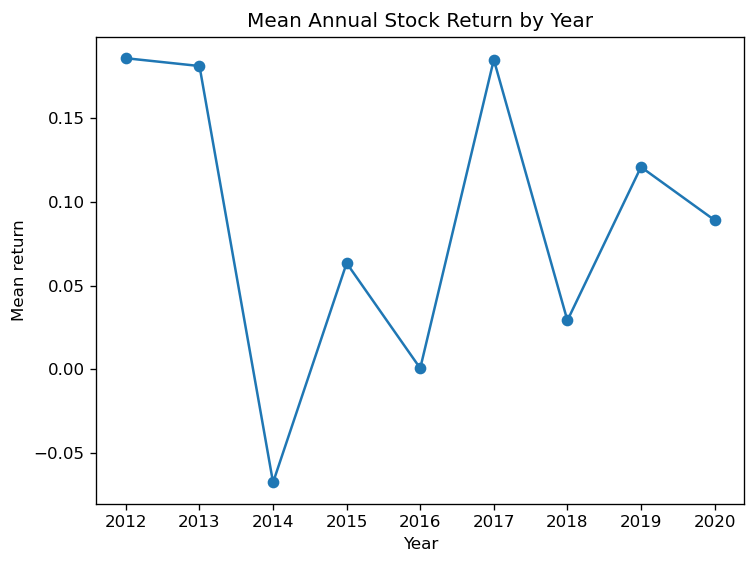

In [57]:
mean_by_year = model_lags.groupby(YEAR_COL)[DV_COL].mean()
plt.figure(dpi=120)
mean_by_year.plot(marker="o")
plt.title("Mean Annual Stock Return by Year"); plt.xlabel("Year"); plt.ylabel("Mean return")
plt.tight_layout(); plt.savefig("outputs/fig_trend_return.png", dpi=300); plt.show()

#### 4.2. Histograms: DV and logLag1

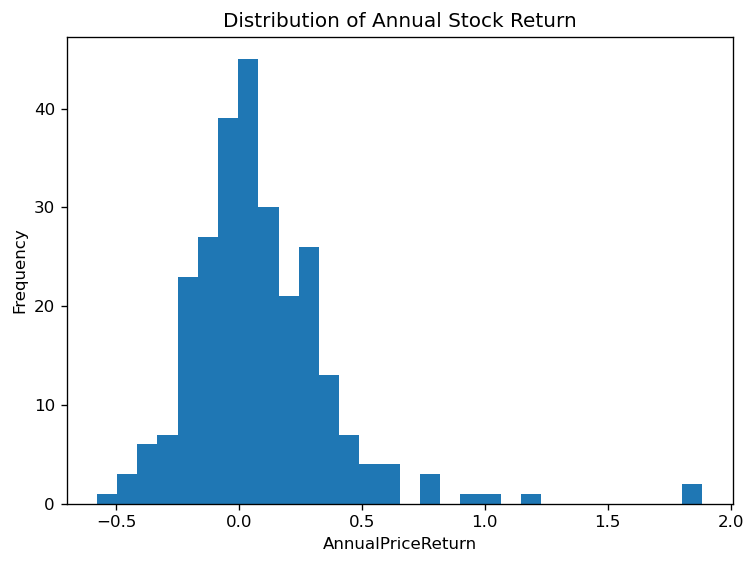

In [59]:
plt.figure(dpi=120)
panel[DV_COL].dropna().plot(kind="hist", bins=30)
plt.title("Distribution of Annual Stock Return"); plt.xlabel(DV_COL)
plt.tight_layout(); plt.savefig("outputs/fig_hist_return.png", dpi=300); plt.show()

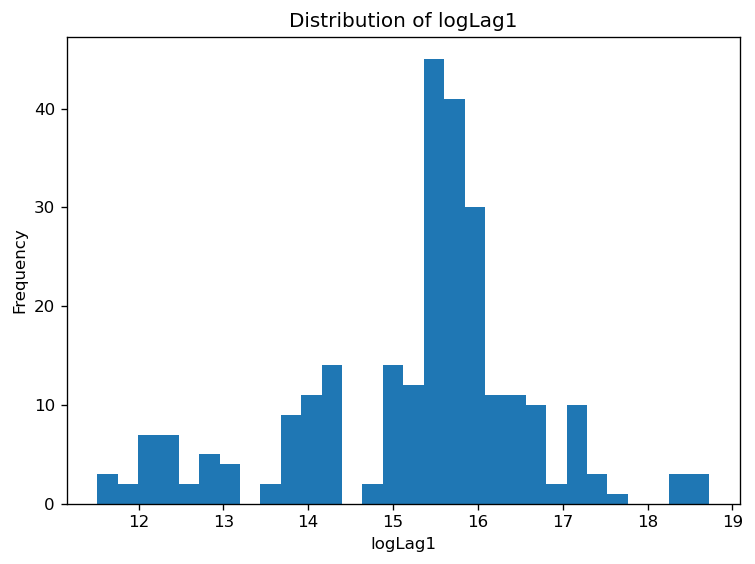

In [60]:
plt.figure(dpi=120)
panel["logLag1"].dropna().plot(kind="hist", bins=30)
plt.title("Distribution of logLag1"); plt.xlabel("logLag1")
plt.tight_layout(); plt.savefig("outputs/fig_hist_logLag1.png", dpi=300); plt.show()

#### 4.3. Binned scatter: logLag1 vs DV

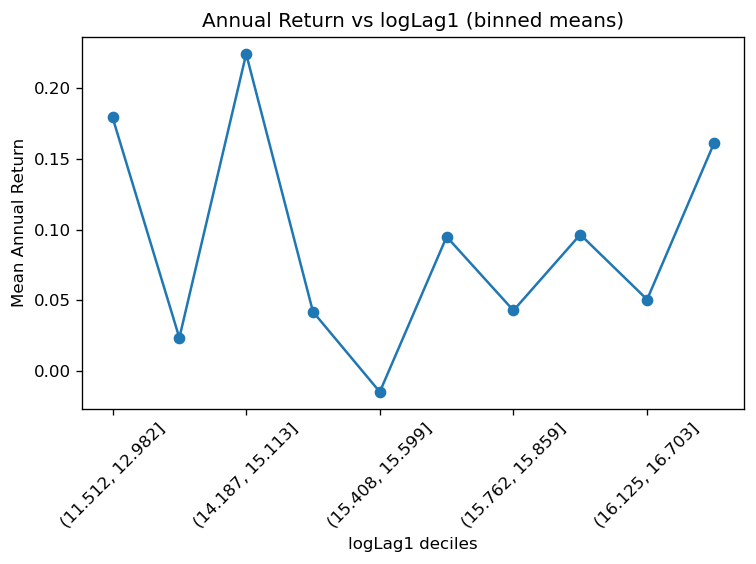

In [62]:
tmp = panel[["logLag1", DV_COL]].dropna().copy()
tmp["bin"] = pd.qcut(tmp["logLag1"], q=10, duplicates="drop")
b = tmp.groupby("bin")[DV_COL].mean()

fig, ax = plt.subplots(dpi=120)
b.plot(marker="o", ax=ax)
ax.set_title("Annual Return vs logLag1 (binned means)")
ax.set_xlabel("logLag1 deciles"); ax.set_ylabel("Mean Annual Return")
ax.tick_params(axis='x', labelrotation=45)  # vertical tick labels
fig.tight_layout(); fig.savefig("outputs/fig_binned_return_logLag1.png", dpi=300)
plt.show()

#### 4.4. Coefficient plot with 95% CI from FE results

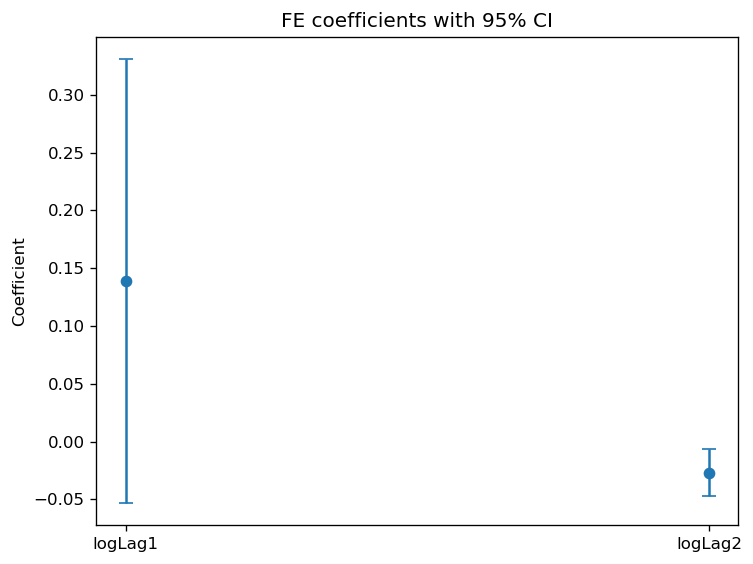

In [64]:
params = [p for p in ["logLag1","logLag2"] if p in fe_res.params.index]
coef = fe_res.params.loc[params]
ci   = fe_res.conf_int().loc[params]
lo, hi = ci.columns[0], ci.columns[1]

x = np.arange(len(params))
fig, ax = plt.subplots(dpi=120)
ax.errorbar(x, coef.values,
            yerr=[coef.values - ci[lo].values, ci[hi].values - coef.values],
            fmt='o', capsize=4)
ax.set_xticks(x); ax.set_xticklabels(params)
ax.set_title("FE coefficients with 95% CI"); ax.set_ylabel("Coefficient")
fig.tight_layout(); fig.savefig("outputs/fig_coef_fe.png", dpi=300)
plt.show()